In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

image_path = '/kaggle/input/kermany2018/oct2017/OCT2017 '
oct_csv_path = '/kaggle/input/oct-csv/'
oct_singan_path = '/kaggle/input/octsingan/'
train_dir = image_path + "/train/"
valid_dir = image_path + "/val/"
test_dir = image_path + "/test/"

In [2]:
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
cols = [x.upper() for x in classes]
dirs = [train_dir, valid_dir, test_dir]
label = {0: 'CNV', 1: 'DME', 2: 'DRUSEN', 3: 'NORMAL'}
IMG_SIZE = 224

# if we should read the directory structre, if False then use the CSV files already saved
# Once you generate the csv files you should probably download them and re-upload into kaggle and set this to FALSE
REGEN = False 

In [3]:
def create_df (path, classes=classes):
  df = pd.DataFrame(columns=['FILENAME', 'CNV', 'DME', 'DRUSEN', 'NORMAL'])
  for sub_dir in classes:
    condition = {'NORMAL': 0, 'CNV': 0, 'DME':0, 'DRUSEN': 0}
    files = os.listdir(path + sub_dir)
    if (sub_dir== 'NORMAL'):
      condition['NORMAL'] = 1
    elif (sub_dir == 'CNV'):
      condition['CNV'] = 1
    elif (sub_dir == 'DME'):
      condition['DME'] = 1
    else:
      condition['DRUSEN']= 1
    for f in files:
      df = df.append({'FILENAME': path +  sub_dir  + "/" + f, 
                      'NORMAL': condition['NORMAL'], 
                      'CNV': condition['CNV'],
                      'DME': condition['DME'],
                      'DRUSEN': condition['DRUSEN']}, ignore_index=True)
  return df

In [4]:
# Generting the DataFrames of the filenames
# this is primarily used so we can sub-sample files easier for the different training strategies
if (REGEN):
  train_df = create_df(train_dir)
  valid_df = create_df(valid_dir)
  test_df = create_df(test_dir)
  singan_df = create_df(oct_singan_path)
  train_df.to_csv("train_data.csv")
  valid_df.to_csv("valid_data.csv")
  test_df.to_csv("test_data.csv")
  singan_df.to_csv("singan_data.csv")
else:
  train_df = pd.read_csv(oct_csv_path + "train_data.csv")
  valid_df = pd.read_csv(oct_csv_path + "valid_data.csv")
  test_df = pd.read_csv(oct_csv_path + "test_data.csv")
  singan_df = pd.read_csv(oct_csv_path + "singan_data.csv")

In [5]:
print ("Training Data: ", train_df.shape)
print ("Validation Data: ", valid_df.shape)
print ("Test Data: ", test_df.shape)
print ("SinGAN Data: ", singan_df.shape)

Training Data:  (83484, 5)
Validation Data:  (36, 5)
Test Data:  (972, 5)
SinGAN Data:  (12552, 5)


In [6]:
# Printing out the # of samples for each subsample percentage 
print ("Trainig Data percentages:")
print (" 1% ==> ", int(.01 * train_df.shape[0]))
print (" 5% ==> ", int(.05 * train_df.shape[0]))
print ("10% ==> ", int(.1  * train_df.shape[0]))
print ("25% ==> ", int(.25 * train_df.shape[0]))
print ("50% ==> ", int(.5  * train_df.shape[0]))
print ("75% ==> ", int(.75 * train_df.shape[0]))
print ("90% ==> ", int(.9  * train_df.shape[0]))
print ("98% ==> ", int(.98 * train_df.shape[0]))

Trainig Data percentages:
 1% ==>  834
 5% ==>  4174
10% ==>  8348
25% ==>  20871
50% ==>  41742
75% ==>  62613
90% ==>  75135
98% ==>  81814


In [7]:
singan_df.head(10)

,FILENAME,CNV,DME,DRUSEN,NORMAL
0,/kaggle/input/octsingan/CNV/47_CNV-7422289-24....,1,0,0,0
1,/kaggle/input/octsingan/CNV/7_CNV-7585537-2.jpeg,1,0,0,0
2,/kaggle/input/octsingan/CNV/35_CNV-6652117-496...,1,0,0,0
3,/kaggle/input/octsingan/CNV/41_CNV-81630-49.jpeg,1,0,0,0
4,/kaggle/input/octsingan/CNV/24_CNV-6566667-23....,1,0,0,0
5,/kaggle/input/octsingan/CNV/23_CNV-6652117-338...,1,0,0,0
6,/kaggle/input/octsingan/CNV/34_CNV-5603164-96....,1,0,0,0
7,/kaggle/input/octsingan/CNV/9_CNV-7555604-53.jpeg,1,0,0,0
8,/kaggle/input/octsingan/CNV/4_CNV-7513011-135....,1,0,0,0
9,/kaggle/input/octsingan/CNV/16_CNV-135126-3.jpeg,1,0,0,0


In [8]:
# Sampling 10% of the data
sample = train_df.sample(frac=0.1, random_state=10, axis=0)
sample = sample.append(singan_df, ignore_index=False)
sample = sample.sample(frac=1, random_state=10, axis=0)

In [9]:
# determine class weights to feed into neural network during training
def get_classweight(df):
  total = df.shape[0]
  num_norm = df['NORMAL'].sum()
  num_cnv = df['CNV'].sum()
  num_dme = df['DME'].sum()
  num_drusen = df['DRUSEN'].sum()
  norm_weight = (1/num_norm) * (total/4)
  cnv_weight = (1/num_cnv) * (total/4)
  dme_weight = (1/num_dme) * (total/4)
  drusen_weight = (1/num_drusen) * (total/4)
  class_weight = {0 : cnv_weight, 1: dme_weight,
                  2 : drusen_weight, 3: norm_weight}
  return class_weight

In [10]:
class_weight = get_classweight(sample)
class_weight

{0: 0.7046527309507755,
 1: 1.3069034517258629,
 2: 1.2669738118331717,
 3: 0.9742681335073653}

In [12]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow.keras.applications as app
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
train_image_datagen = ImageDataGenerator(rotation_range=90, width_shift_range=[-.1,.1], height_shift_range=[-.1,.1],
                                         shear_range=0.25, zoom_range=0.3, horizontal_flip=True,
                                         vertical_flip=True, rescale = 1./255., validation_split=0.1)

# Setting the imgages to come from the dataframe where we specify the filenames and columns to use for "labels"
train_imgs = train_image_datagen.flow_from_dataframe(sample, directory=None, x_col='FILENAME', y_col=cols, subset="training",
                                        class_mode="raw", target_size=(IMG_SIZE,IMG_SIZE), batch_size=32, seed=10)
valid_imgs = train_image_datagen.flow_from_dataframe(sample, directory=None, x_col='FILENAME', y_col=cols, subset="validation",
                                        class_mode="raw", target_size=(IMG_SIZE,IMG_SIZE), batch_size=32, seed=10)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4 invalid image filename(s) in x_col="FILENAME". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 18807 validated image filenames.
Found 2089 validated image filenames.


In [14]:
# Creating the model based on Xception Network
input_layer = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = app.xception.Xception(include_top=False, weights="imagenet", input_shape=(IMG_SIZE,IMG_SIZE,3))


x = base_model(input_layer)
x = keras.layers.GlobalAveragePooling2D()(x)
output = keras.layers.Dense(4, activation="softmax")(x)


# set base_model layers trainable

base_model.trainable = True

set_trainable = False

# set all layers to trainable
for layer in base_model.layers:
    if layer in base_model.layers[126:] :
        set_trainable = True
        layer.trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False 


model = keras.Model(inputs=input_layer, outputs=output)

83689472/83683744 [==============================] - 3s 0us/step


In [15]:
# layer trainable status of base_model layers
layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_2,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.normalization_...,block1_conv1_bn,False
3,<tensorflow.python.keras.layers.core.Activatio...,block1_conv1_act,False
4,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
...,...,...,...
127,<tensorflow.python.keras.layers.normalization_...,block14_sepconv1_bn,True
128,<tensorflow.python.keras.layers.core.Activatio...,block14_sepconv1_act,True
129,<tensorflow.python.keras.layers.convolutional....,block14_sepconv2,True
130,<tensorflow.python.keras.layers.normalization_...,block14_sepconv2_bn,True


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 4,756,996
Non-trainable params: 16,112,680
_________________________________________________________________


In [17]:
# This code did not work, it caused I/O Error 5:
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics='accuracy')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=["accuracy"])

In [18]:
# Creating a checkpoint to save the best model so that we can reload it once training is complete
checkpoint_cb = keras.callbacks.ModelCheckpoint("oct_singan.h5", save_best_only=True)
# Adding an an early stop callback to avoid overfitting in case the model is not improving after 5 consescutive epochs
earlystop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [19]:
history = model.fit(train_imgs,  epochs=30, verbose=1, validation_data=valid_imgs, 
                    class_weight=class_weight, callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/30
588/588 [==============================] - 385s 640ms/step - loss: 0.8833 - accuracy: 0.6435 - val_loss: 0.6726 - val_accuracy: 0.7329
Epoch 2/30
588/588 [==============================] - 279s 473ms/step - loss: 0.6578 - accuracy: 0.7454 - val_loss: 0.6159 - val_accuracy: 0.7664
Epoch 3/30
588/588 [==============================] - 281s 478ms/step - loss: 0.6026 - accuracy: 0.7671 - val_loss: 0.6125 - val_accuracy: 0.7635
Epoch 4/30
588/588 [==============================] - 284s 483ms/step - loss: 0.5595 - accuracy: 0.7869 - val_loss: 0.5842 - val_accuracy: 0.7592
Epoch 5/30
588/588 [==============================] - 276s 469ms/step - loss: 0.5338 - accuracy: 0.7912 - val_loss: 0.5364 - val_accuracy: 0.7932
Epoch 6/30
588/588 [==============================] - 273s 464ms/step - loss: 0.5135 - accuracy: 0.8107 - val_loss: 0.5332 - val_accuracy: 0.7913
Epoch 7/30
588/588 [==============================] - 279s 475ms/step - loss: 0.5014 - accuracy: 0.8123 - val_loss: 0.4429 -

In [20]:
test_image_datagen = ImageDataGenerator( rescale = 1./255.)

test_imgs = test_image_datagen.flow_from_dataframe(test_df, directory=None, x_col='FILENAME', y_col=cols, validate_filenames=True,
                                        class_mode="raw", target_size=(224,224), batch_size=32, shuffle=False)

Found 968 validated image filenames.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 4 invalid image filename(s) in x_col="FILENAME". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [21]:
model.load_weights("oct_singan.h5")
model.evaluate(test_imgs)

31/31 [==============================] - 10s 316ms/step - loss: 0.2289 - accuracy: 0.9236


[0.2288774996995926, 0.9235537052154541]

KeyError: 'f1_score'

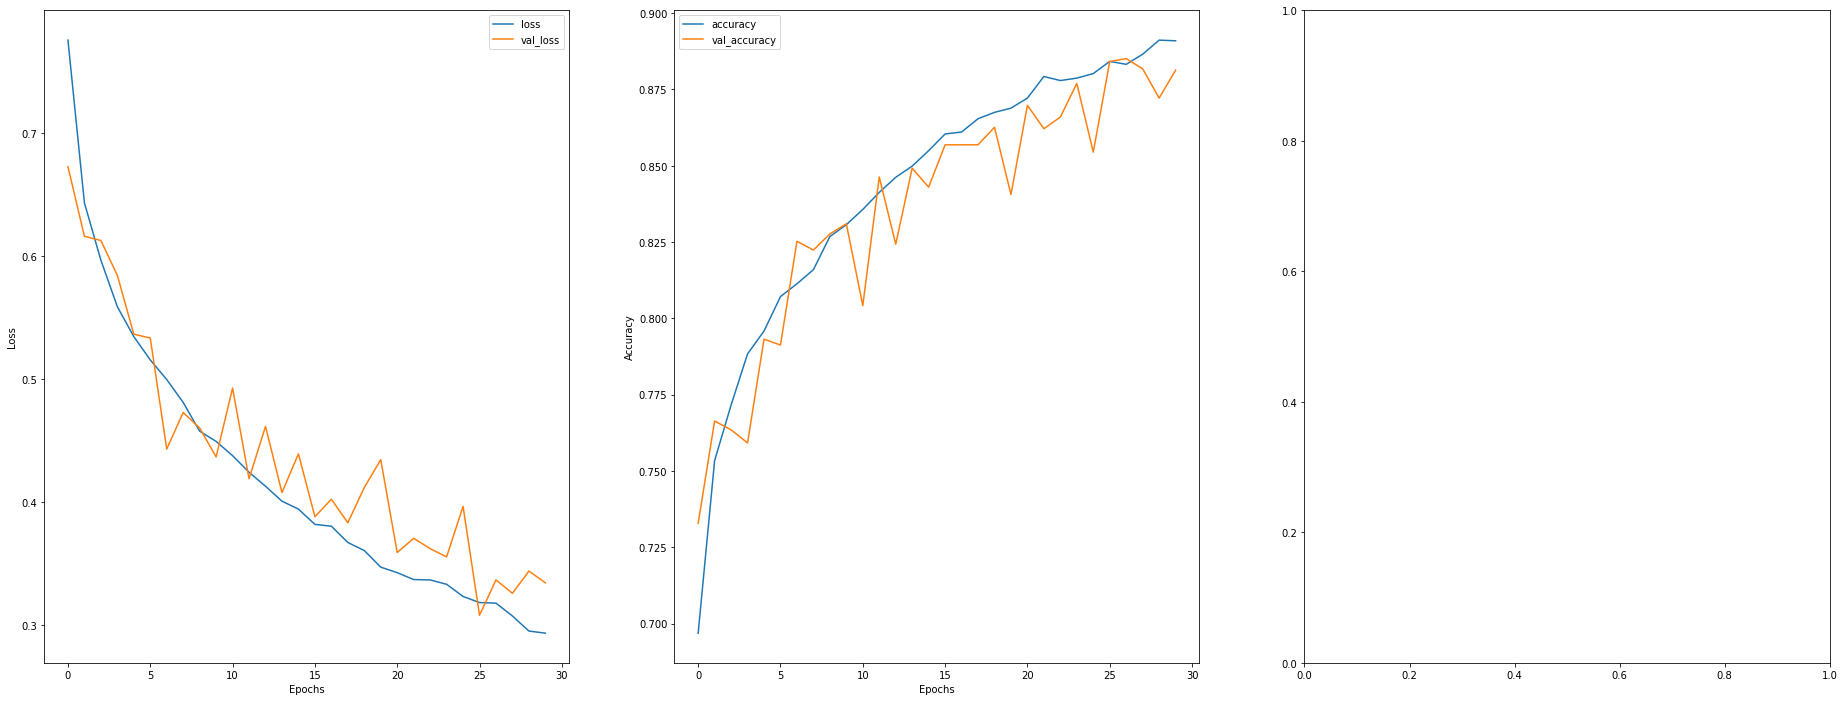

In [22]:
#Plotiting training results
plt.figure(figsize=(32,12))
plt.subplot(1,3,1)
plt.plot(range(len(history.history["loss"])), history.history['loss'], label="loss")
plt.plot(range(len(history.history["loss"])), history.history['val_loss'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,3,2)
plt.plot(range(len(history.history["loss"])), history.history["accuracy"], label="accuracy")
plt.plot(range(len(history.history["loss"])), history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,3,3)
plt.plot(range(len(history.history["loss"])), history.history['f1_score'], label="loss")
plt.plot(range(len(history.history["loss"])), history.history['val_f1_score'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [23]:
tf.saved_model.save(model, 'Xception10per6laySinGANOCT')

# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model('Xception10per6laySinGANOCT')# YOUR CODE HERE

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE] # YOUR CODE HERE]

# Use the tool to finally convert the model
tflite_model = converter.convert()

tflite_model_file = 'Xception10per6laySinGANOCT.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)